In [79]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.fft import fftshift
import seaborn as sns
import matplotlib.pylab as pl
import bites as bt

In [80]:
plt.rcParams['pdf.fonttype'] = 42

In [81]:
vid_folder = "/Users/loaner/Documents/GitHub/bite-tracks/sample_leg/"
plot_folder = "/Users/loaner/Documents/GitHub/bite-tracks/plots/"

In [92]:
vid = 'video2/'

In [94]:
legDf = pd.read_csv(vid_folder+vid+"skito_cartoon_S0001DLC_resnet50_deet4Mar6shuffle1_280000.csv",header=[1,2],index_col=0)

## Radius Estimation

In [95]:
def rad_est(points,org):
    r = np.mean(np.sqrt((points[:,0]-org[0])**2 + (points[:,1]-org[1])**2))
    return r

In [96]:
n_circ_points = 9

In [97]:
circ_points = np.array([legDf['ci'+str(i)].iloc[:,:2].values for i in range(1,n_circ_points+1)])

In [98]:
orgs = legDf['Org'].iloc[:,:2].values

In [99]:
r = np.zeros(orgs.shape[0])
for f in range(orgs.shape[0]):
    r[f] = rad_est(circ_points[:,f,:],orgs[f,:])

In [100]:
mask = sp.ndimage.gaussian_filter(legDf['Org']['likelihood'],10)>0.95

## Modeling as Diffusion

In [101]:
prop = 0.3
growth = r[mask][:int(np.sum(mask)*prop)]

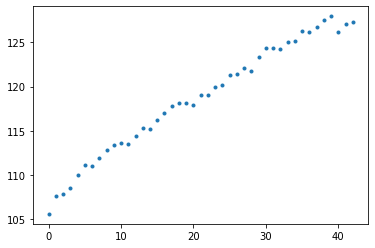

In [102]:
plt.plot(growth,'.');

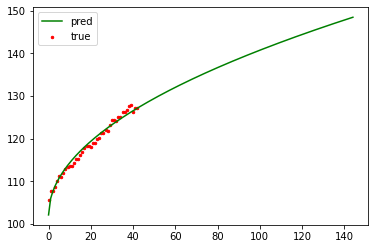

In [103]:
from scipy.optimize import curve_fit

def func(t,a,b):
    return a*((t)**(1/2))+b

t = np.arange(len(growth))
t_full = np.arange(np.sum(mask))

popt, pcov = curve_fit(func,t,growth)
growth_fit = func(t_full,*popt)

fig,ax = plt.subplots()
ax.scatter(t,growth,c='r',label='true',s=6)
ax.plot(t_full,growth_fit,c='g',label='pred')
ax.legend(loc='best');

## Foot Distance From Origin

In [104]:
d_foot = np.sqrt(np.sum((legDf['tar1'].iloc[:,:2].values-legDf['Org'].iloc[:,:2])**2,axis=1))

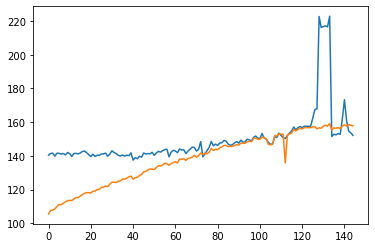

In [106]:
plt.plot(range(np.sum(mask)),d_foot[mask]);
plt.plot(range(np.sum(mask)),r[mask]);

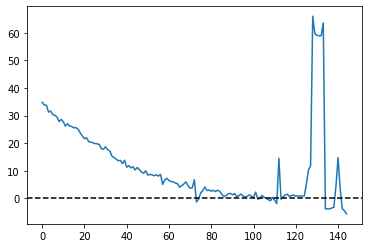

In [107]:
dist_to_front = d_foot[mask]-r[mask]
plt.plot(range(np.sum(mask)),dist_to_front);
plt.axhline(0,linestyle='--',color='k');

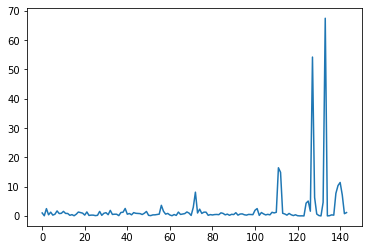

In [116]:
plt.plot(np.abs(np.diff(dist_to_front)));